# Machine Learning Nanodegree

## Transfer Learning for Image Classification

## Capstone Project: Write an Algorithm to Classify Plant Seedlings


### Motivation 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Plant Output](images/0bdaf1d8f.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Data Processing
* [Step 3](#step3): Benchmark Model. A simple ConvNet made from scratch
* [Step 4](#step4): Transfer Learning. Utilize Inception V3 to develop a ConvNet.
* [Step 5](#step5): Final Model Evaluation

---
<a id='step1'></a>
## Step 1: Import Datasets

### Import Plant Dataset

In the code cell below, a small dataset of plant images is imported.  A few variables are populated through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `plant_names` - list of string-valued dog breed names for translating labels

In [1]:
import sys
from importlib import reload

# Add user-defined functions to path
sys.path.insert(0, 'auxiliary_functions')

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load the image data
def load_dataset(path, numClasses = 12):
    data = load_files(path)
    plant_files = np.array(data['filenames'])
    plant_targets = np_utils.to_categorical(np.array(data['target']), numClasses)
    return plant_files, plant_targets

# load the data
numPlantClasses = 12
plant_files, plant_targets = load_dataset('plantImages/fullDataSet', numPlantClasses)

# load list of plant names
plant_names = [item[24:-1] for item in sorted(glob("plantImages/fullDataSet/*/"))]

# Print basic statistics about the data set
print('There are %d total plant categories.' % len(plant_names))
print('There are %d plant images.' % len(plant_files))
print('The plant names are: ')
print(plant_names)

Using TensorFlow backend.


There are 12 total plant categories.
There are 4750 plant images.
The plant names are: 
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


<a id='step1'></a>
## Step 1: Data Processing

### Split the Images into Training and Test Sets

In [3]:
from sklearn.model_selection import train_test_split

# Split plant_files into train_files, valid_files, and test_files. Write them to file
randState = 0  # for reproducibility
alltrain_files, test_files, alltrain_targets, test_targets = train_test_split(
                                                                              plant_files, 
                                                                              plant_targets, 
                                                                              test_size = 0.20, 
                                                                              random_state = randState,
                                                                              stratify = plant_targets)

# Print basic statistics about the training and test sets
print('There are %d images for training and validation.' % len(alltrain_files))
print('There are %d images for testing.' % len(test_files))
print ('')
print('There are %d training and validation targets.' % len(alltrain_targets))
print('There are %d test targets.' % len(test_targets))

There are 3800 images for training and validation.
There are 950 images for testing.

There are 3800 training and validation targets.
There are 950 test targets.


### Further split the Training Set into 'Train' and 'Validation'

In [4]:
# Split training into 'train' and 'validation'
train_files, valid_files, train_targets, valid_targets = train_test_split(
                                                                          alltrain_files, 
                                                                          alltrain_targets, 
                                                                          test_size = 0.25, 
                                                                          random_state = randState,
                                                                          stratify = alltrain_targets)

# Print basic statistics about the training and test sets
print('There are %d images for training.' % len(train_files))
print('There are %d images for validation.' % len(valid_files))
print('There are %d images for testing.' % len(test_files))
print ('')
print('There are %d training targets.' % len(train_targets))
print('There are %d validation targets.' % len(valid_targets))
print('There are %d test targets.' % len(test_targets))

There are 2850 images for training.
There are 950 images for validation.
There are 950 images for testing.

There are 2850 training targets.
There are 950 validation targets.
There are 950 test targets.


### One Hot Encode the Plant Classes

In [5]:
# Generate Identity matrix for one-hot encoding of classes
plantCategories = np.zeros((numPlantClasses, numPlantClasses))
for row in range(0,numPlantClasses):
    plantCategories[row][row] = 1.

# Print the one-hot encodings    
print(plantCategories)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


### Visualize the class distribution of image data

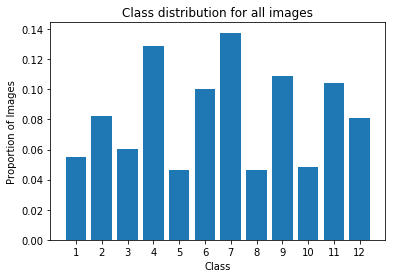

In [6]:
from IPython.display import display, Image
from viz import create_bar_chart
import numpy as np

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

create_bar_chart(plant_targets, plantCategories, titleString = 'Class distribution for all images')

### Class Distribution of Train Set

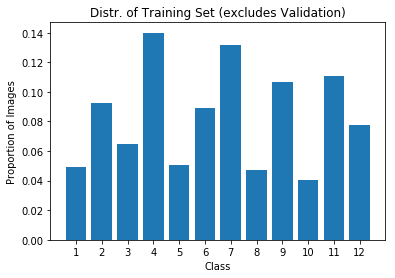

In [7]:
create_bar_chart(train_targets, plantCategories, titleString = 'Distr. of Training Set (excludes Validation)')

### Class Distribution of Validation Set

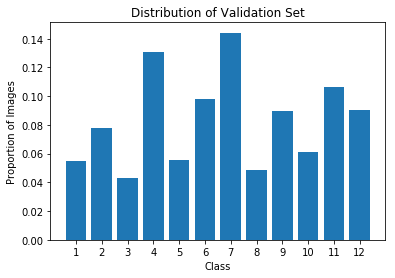

In [8]:
create_bar_chart(valid_targets, plantCategories, titleString = 'Distribution of Validation Set')

### Class Distribution of Test Set

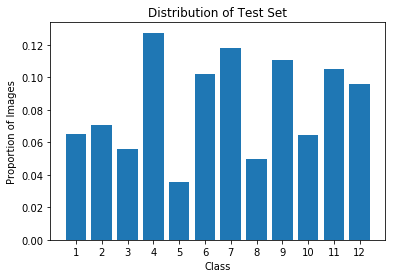

In [9]:
create_bar_chart(test_targets, plantCategories, titleString = 'Distribution of Test Set')

### Image Pre-processing for the home-made CNN

Rescale the images by dividing every pixel in every image by 255. First a couple of helpful functions are defined to convert images into tensors:

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

# These functions are borrowed from the following Udacity repo:
#
def path_to_tensor(img_path, targetImageSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(targetImageSize, targetImageSize))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, targetImageSize):
    list_of_tensors = [path_to_tensor(img_path, targetImageSize) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

The scaling and tensor conversion is performed in the next code cell:

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

NORMALIZATION_FACTOR = 255
plantsImageSize = 224

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR
valid_tensors = paths_to_tensor(valid_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR
test_tensors = paths_to_tensor(test_files, plantsImageSize).astype('float32')/NORMALIZATION_FACTOR

100%|██████████| 950/950 [00:10<00:00, 91.05it/s] 


---
<a id='step2'></a>
## Step 2: Benchmark Model. A simple ConvNet made from scratch


### Compile and Train Benchmark CNN

Here I create a CNN from scratch. The model is compiled and trained in the code cells below. Model checkpointing is used to save the model that attains the best validation loss. The model achieves a ??? % classification rate, which is slightly better than random guessing. It also earns an F1-score of ??.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from modelGen import create_benchmark_CNN
from project_metrics import Metrics

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [83]:
class Metrics(Callback):
    ''' 
    class that calculates f1, precision, and recall scores after 
    
    Code borrowed (and adapted) from the following blog:
    https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
    '''
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        return
    
    def on_epoch_end(self, epoch, logs={}):
        val_p = self.model.predict(self.validation_data[0])
        val_predict = [np.argmax(val_p[idx]) for idx in range(len(val_p))]
        val_t = self.validation_data[1]
        val_targ = [np.argmax(val_t[idx]) for idx in range(len(val_t))]
        _val_f1 = f1_score(val_targ, val_predict, average = 'micro')
        val_recall_score = recall_score(val_targ, val_predict, average = 'micro')
        val_precision_score = precision_score(val_targ, val_predict, average = 'micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(val_recall_score)
        self.val_precisions.append(val_precision_score)
        print("— val_f1: {f1}".format(f1 = _val_f1))
        return

In [84]:
# Import user-defined class to compute f1-score, precision, recall
thisProjectsMetrics = Metrics()

# See modelGen.py for definition of create_benchmark_CNN()
nEpochs = 2
batchSize = 20

benchmark = create_benchmark_CNN(plantsImageSize = 224, drop_outA = 0.1, drop_outB = 0.1, neurons = 500)
benchmark.summary()

# benchmark = KerasClassifier(build_fn = create_benchmark_CNN, 
#                            epochs = nEpochs, 
#                            batch_size = batchSize)


# Define GridSearchCV parameters
neuronOptions = [1000, 500, 250, 125, 62, 32]
dropOut = [0.1, 0.2, 0.3, 0.4, 0.5]

# Place grid search params into dictionary
#paramGrid = dict(neurons = neuronOptions, drop_outA = dropOut, drop_outB = dropOut)

#grid = GridSearchCV(estimator = benchmark, 
#                    param_grid = paramGrid, 
#                    scoring = 'f1_micro',
#                    n_jobs=-1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 224, 224, 16)      1040      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 112, 112, 32)      4128      
_________________________________________________________________
dropout_31 (Dropout)         (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 56, 56, 32)        0         
__________

In [85]:
# Train the model
#grid.fit(train_tensors, train_targets)

# Define checkpointer
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Train the model
benchmark.fit(train_tensors, train_targets, 
              validation_data = (valid_tensors, valid_targets),
              epochs = nEpochs,
              batch_size = batchSize,
              callbacks = [thisProjectsMetrics],
              verbose = 1)

Train on 2850 samples, validate on 950 samples
Epoch 1/2
2850/2850 [==============================] - 30s - loss: 2.3227 - acc: 0.1874 - val_loss: 1.7898 - val_acc: 0.3947
Epoch 2/2
2850/2850 [==============================] - 29s - loss: 1.3273 - acc: 0.5498 - val_loss: 1.1422 - val_acc: 0.6032


In [ ]:
### Do NOT modify the code below this line.
# Model checkpoint and fitting
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
#                               verbose=1, 
#                               save_best_only=True)

#simpleCNN.fit(train_tensors, 
#              train_targets, 
#              validation_data=(valid_tensors, valid_targets),
#              epochs = nEpochs, 
#              batch_size = batchSize, 
#              callbacks = [checkpointer, thisProjectsMetrics], 
#              verbose=1)

### Test the Benchmark Model

The benchmark CNN is evaluated on the test dataset of plant seedlings images. The test accuracy is 72.8%. This is greater than 8.33%, which is the accuracy rate for random guessing. The F1-score on the test set is ???

In [1]:
# Extends the f1_score to tensor inputs
from project_metrics import microaveraged_f1score

# Load the weights yielding the best validation loss
benchmark.load_weights('saved_models/weights.best.from_scratch.hdf5')

# Make predictions with Test Set
#predictionsWithBenchmark = [benchmark.predict(np.expand_dims(tensor, axis=0)) for tensor in test_tensors]
predictionsWithBenchmark = predict_with_tensors(benchmark, test_tensors)

# Determine F1-score
F1ScoreBenchmark = microaveraged_f1score(test_targets, predictionsWithBenchmark)
# RecallBenchmark =  recall_score(test_targets, predictionsWithBenchmark)
# PrecisionBenchmark = precision_score(test_targets, predictionsWithBenchmark)

# Print F1-score to console
print("This model's F1-score is ", F1ScoreBenchmark)
# print("This model's recall is ", RecallBenchmark)
# print("This model's precision is ", PrecisionBenchmark)

ImportError: No module named 'custom_metrics'

---
<a id='step3'></a>
## Step 3: Transfer Learning. Utilize Inception V3 to develop a ConvNet.

In this section transfer learning will be used to train a CNN. The goal is to take advantage of Inception V3, a pre-trained CNN that has already been trained on ImageNet, a standard computer vision that contains images of both natural and man-made objects. None of the categories of the ImageNet database include plants, so this application of transfer learning will rely on the general features that Inception V3 has extracted from ImageNet.

### Load Inception V3, peel away some layers, and train

In [ ]:
from modelGen import load_pretrain_CNN, generate_bottleneck_features, create_top_model
from modelGen import fully_connected_toplayer

# Import a pre-trained Convolutional Neural Network trained on ImageNet
model = load_pretrain_CNN(modelName = 'InceptionV3', imageSize = plantsImageSize, layers_to_keep = 12)
model.summary()

In [5]:
# Use Image Generator to generate bottleneck features with Inception model
bottleneck_train, bottleneck_valid = generate_bottleneck_features(model, 
                                                                  x_train, 
                                                                  y_train, 
                                                                  x_valid, 
                                                                  y_valid, 
                                                                  imageSize = plantsImageSize, 
                                                                  batchSize = 32)

# Load a fully connected network and train it with the bottleneck features
batchSizes = [15 25 35]
nEpochs = [25 50 75 100]
topLayers = KerasClassifier(build_fn = fully_connected_toplayer, epochs=nEpochs, batch_size=batchSizes, verbose=0)

#topLayers = fully_connected_toplayer(model.output_shape[1:], 
#                                     learningRate = 0.001, 
#                                     beta1 = 0.9, 
#                                     beta2 = 0.999)

# Set parameters for training
filepath_best_topLayers = 'saved_models/weights.best.topLayers.hdf5'
checkpointer = ModelCheckpoint(filepath = filepath_best_topLayers, verbose=1, save_best_only=True)

# define the grid search parameters
learnRates = [0.001, 0.01, 0.1, 1.0]
beta1Vals = [0.85, 0.90, 0.95, 0.99]
beta2Vals = [0.999, 0.975, 0.950, 0.925]
param_grid = dict(learn_rate = learnRates, beta_1 = beta1Vals, beta_2 = beta2Vals)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

# Train the top model
#nEpochs = 50
#batchSize = 32
#topLayers_history = topLayers.fit(bottleneck_train, 
#                                train_targets, 
#                                validation_data = (bottleneck_valid, valid_targets),
#                                epochs = nEpochs, 
#                                batch_size = batchSize, 
#                                callbacks = [checkpointer, thisProjectsMetrics], 
#                                verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 111, 111, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 111, 111, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 111, 111, 32)  0                                            
___________________________________________________________________________________________

### Plot Training & Validation Results

In [ ]:
# list all data in history
print(topLayers_history.history.keys())

In [ ]:
plot_model_acc_loss(topLayers_history)

### Combine trained top model with (reduced) Inception V3

In [ ]:
from modelGen import fully_connected_fine_tuning

# Load the model weights with the best validation loss.
topLayers = fully_connected_fine_tuning(InputShape = topLayers.output_shape[1:])
topLayers.load_weights(filepath_best_topLayers)

# Combine the Inception base model with the trained top model
model.add(topLayers)

numLayersToFreeze = 9

# Freeze several layers of weights of base model
for layer in model.layers[:numLayersToFreeze]
    layer.trainable = False

### Train the entire network

In [ ]:
from keras import optimizers

# Compile the combined model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.SGD(lr=1e-4, momentum=0.9), 
              metrics = ['accuracy'])

# Train the combined model, again using image augmentation
batchSize = 32

# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(train_data_dir,
                                     target_size = (plantsImageSize, plantsImageSize),
                                     batch_size = batchSize,
                                     shuffle = False,
                                     seed = 0,
                                     class_mode='None')


validation_generator = test_datagen.flow(validation_data_dir,
                                         target_size = (img_height, img_width),
                                         batch_size = batchSize,
                                         shuffle = False,
                                         seed = 0,
                                         class_mode = 'None')

# fine-tune the combined model
filepath_best_combinedModel = 'saved_models/weights.best.combinedModel.hdf5'
checkpointer = ModelCheckpoint(filepath = filepath_best_combinedModel, verbose=1, save_best_only=True)

model_History = model.fit_generator(train_generator,
                                    steps_per_epoch = nb_train_samples // batchSize,
                                    epochs = Nepochs,
                                    validation_data = validation_generator,
                                    validation_steps = nb_validation_samples // batchSize,
                                    callbacks = [checkpointer, thisProjectsMetrics])

### Plot Evaluation Metrics

In [ ]:
plot_model_acc_loss(model_History)

<a id='step4'></a>
## Step 4: Final Model Evaluation

In [ ]:
# Make Predictions
finalPredictions = predict_with_tensors(model, test_tensors):

# Determine F1-score
modelF1Score = microaveraged_f1score(test_targets, finalPredictions)

# Print to console
print("This model's F1-score is ", modelF1Score)